# Wavelet and simulated Annealing SliP (WASP) Tutorial
***
***
The Wavelet and simulated Annealing SliP (WASP) code is for finite fault inversions (slip inversions) using a non-linear inversion method in the wavelet domain to model slip amplitude, rake, rupture time, and rise time on a discretized fault plane (Ji et al., 2002). To solve the non-linear problem, WASP uses the heat-bath simulated annealing inverse method. WASP has been developed by Pablo Koch (University of Chile, Santiago) with Python wrappers to the underlying Fortran scripts (Ji et al., 2002; Koch et al., 2019; Goldberg et al., 2022).

WASP has been tested on Linux machines and on a PC using Windows Subsystem for Linux.  
***  
<div>
<img src="Tutorial_Figures/SlipDistribution_example.png" width="500"/>
</div>

### This software should be cited as:
Koch, P., Goldberg, D.E., Hunsinger, H., Melgar, D., Riquelme, S., Yeck, W.L., and Haynie, K.L., 2024, Wavelet and simulated Annealing SliP inversion (WASP), version 1.0.0: U.S. Geological Survey software release, https://doi.org/10.5066/P1EKKUNW.
***


### Users of this code should consider citing the following relevant publications:
- Goldberg, D. E., P. Koch, D. Melgar, S. Riquelme, and W. L. Yeck (2022). Beyond the Teleseism: Introducing Regional Seismic and Geodetic Data into Routine USGS Finite Fault Modeling, Seismological Research Letters, 93, 3308–3323, https://doi.org/10.1785/0220220047.
- Ji, C., D. J. Wald, and D. V. Helmberger (2002). Source description of the 1999 Hector Mine, California, earthquake, Part I: Wavelet domain inversion theory and resolution analysis, Bulletin of the Seismological Society of America, 92, no. 4, 1192–1207, https://doi.org/10.1785/0120000916.
- Koch, P., F. Bravo, S. Riquelme, and J. G. F. Crempien (2019). Near-real-time finite-fault inversions for large earthquakes in Chile using strong-motion data, Seismological Research Letters, 90, no. 5, 1971–1986, https://doi.org/10.1785/0220180294.
- Zhu, L., & Rivera, L. A. (2002). A note on the dynamic and static displacements from a point source in multilayered media: A note on the dynamic and static displacements from a point source. Geophysical Journal International, 148(3), 619–627. https://doi.org/10.1046/j.1365-246X.2002.01610.x.
***


### To run a slip inversion, all you need is:
1. a moment tensor (in CMTSOLUTION format), and
2. at least one of the following data types  
    a. broadband teleseismic waveforms,  
    b. local strong-motion accelerometer waveforms,  
    c. local high-rate Global Navigation Satellite Systems (GNSS) displacement waveforms,  
    d. static GNSS offsets, and/ or  
    e. downsampled InSAR interferograms.
    
Waveforms must be in SAC format, and have station name, channel, longitude, and latitude in the header. Static data must be in text files, formatted like the example data (see https://www.sciencebase.gov/catalog/item/62852a66d34e3bef0c9a6316).
***

### This notebook walks through a slip inversion of the 2015 Mw8.3 Illapel, Chile, earthquake.

This tutorial will go through:

1. [Software Installation](#install)  
2. [Running an initial automated inversion: `wasp model run auto_model`](#auto)
3. [Checking the results and making modifications:](#iterate)  
    3.1. [Managing json files and updating parameters in text files: `wasp manage update-inputs`](#input_files)  
    3.2. [The stations included (and their weights): `wasp manage modify-dicts`](#modify_jsons)  
    3.3. [The fault orientation: modify segments_data.json](#segments_data)  
    3.4. [Timing of arrivals: `wasp process shift-match`](#shift_match)  
    3.5. [Modifying the crustal velocity model](#velmod)
4. [Adding data types: `wasp model run manual_model_add_data`](#add_data)  
    4.1. [strong-motion accelerometer](#strong)  
    4.2. [high-rate Global Navigation Satellite Systems (GNSS)](#cgps)  
    4.3. [static GNSS](#gps)  
    4.4. [InSAR line of sight displacements](#insar)
5. [Multi-segment models](#multi_segment)
***


# <a id='install'></a> 1. Installation
The WASP code is housed in a USGS GitLab repository: https://code.usgs.gov/ghsc/neic/algorithms/neic-finitefault.  
Installation instructions are available in the README file at that link: https://code.usgs.gov/ghsc/neic/algorithms/neic-finitefault/-/blob/main/README.md#installation

*The installation script will create and activate the ff-env conda environment. Following this initial instalation, you must activate your environment prior to launching this Jupyter Notebook (e.g., `conda activate ff-env`)*

### <a id='config'></a> 1.1 Check that you have a configuration file
If this is your first time using WASP, set up your configuration file: `!wasp manage write-config`
See your configuration file with the command `!wasp manage show-config` 

### 1.2 Download Tutorial Data 
Necessary data for this tutorial is available in a USGS ScienceBase Data Release: https://www.sciencebase.gov/catalog/item/62852a66d34e3bef0c9a6316
We will download, unzip, and save the following files in the same directory as this tutorial:  

    a. 20003k7a_cmt_CMT  
    b. Teleseismic_Data.zip  
    c. StrongMotion_Accelerometer_Data.zip  
    d. HighRateGNSS_Data.zip  
    e. gps_data  
    f. s1_20150824-20150917_p156_descending.txt  
    g. s1_20150826-20150919_p18_ascending.txt
    
You can download and organize the data manually, or simply by running the cell below (recommended), which will automatically pull the data from ScienceBase and organize the files as needed for the tutorial.

In [ ]:
from glob import glob
import pathlib
import requests
import shutil
import zipfile

# Data files to download from ScienceBase
data_files = ["Teleseismic_Data.zip", "StrongMotion_Accelerometer_Data.zip", "HighRateGNSS_Data.zip", "gps_data", \
              "s1_20150824-20150917_p156_descending.txt", "s1_20150826-20150919_p18_ascending.txt", "20003k7a_cmt_CMT"]

item_url = "https://www.sciencebase.gov/catalog/item/62852a66d34e3bef0c9a6316?format=json"
response = requests.get(item_url)
jdict = response.json()
print(f'Downloading Data from ScienceBase Data Release: \n {jdict["title"]}: {jdict["subTitle"]}')
filenames = [f["name"] for f in jdict["files"]]
for data_download in range(len(data_files)):
    idx = filenames.index(data_files[data_download])
    file_url = jdict["files"][idx]["downloadUri"]
    response2 = requests.get(file_url)
    data = response2.content
    filename = data_files[data_download]
    with open(filename, "wb") as f:
        f.write(data)
    if zipfile.is_zipfile(data_files[data_download]):
        print(f'Unzipping Waveform Data: {data_files[data_download]}')
        myzip = zipfile.ZipFile(data_files[data_download])
        out_dir = data_files[data_download].split('.')[0]
        myzip.extractall(out_dir)
        pathlib.Path(data_files[data_download]).unlink()
print('Creating Static_Data Directory')
static_dir = pathlib.Path('Static_Data')
if not static_dir.exists():
    static_dir.mkdir()
static_files = ["gps_data", "s1_20150824-20150917_p156_descending.txt", "s1_20150826-20150919_p18_ascending.txt"]
for static in range(len(static_files)):
    infile = pathlib.Path(static_files[static])
    outfile = static_dir / static_files[static]
    infile.rename(outfile)
print('DOWNLOAD COMPLETE')

# <a id='auto'></a> 2. We'll start with an initial "auto" inversion.

In [15]:
# Enter the path to your WASP installation:
WASP_directory = str(input("Input path to WASP: "))
# Unless you've moved it, the WASP tutorials is in the WASP_directory under "examples"
WASP_tutorial = WASP_directory + "/examples"

Input path to WASP:  /data/neic-finitefault


Make sure your configuration file looks right. If not, see [configuration file instructions](#config).

In [16]:
!wasp manage show-config


[PATHS]
code_path = /data/neic-finitefault
surf_gf_bank = %(code_path)s/fortran_code/gfs_nm/long/low.in
modelling = %(code_path)s/fortran_code/bin_inversion_gfortran_f95
get_near_gf = %(code_path)s/fortran_code/bin_str_f95
compute_near_gf = %(code_path)s/fortran_code/src_dc_f95
info = %(code_path)s/fortran_code/info
cartopy_files = %(code_path)s/fortran_code/tectonicplates




Let's load and take a look at the example CMT file:  
This is how WASP calculates the nodal planes on which to model slip and from where it pulls the hypocenter and centroid locations, as well as the target seismic moment.

An explanation of the CMTSOLUTION format is available here: http://eost.u-strasbg.fr/wphase/wiki/doku.php/wphase:documentation#data_formats

In [17]:
with open(WASP_tutorial + "/20003k7a_cmt_CMT", "r") as cmt:
    print(cmt.read())

PDE 2015  9 16 22 54 32.90 -31.5700  -71.6700  22.4 0.0 8.3 NEAR COAST OF CENTRAL CH                
event name:     201509162254A  
time shift:     49.9800
half duration:  33.4000
latitude:      -31.1300
longitude:     -72.0900
depth:          17.3500
Mrr:       1.950000e+28
Mtt:      -4.360000e+26
Mpp:      -1.910000e+28
Mrt:       7.420000e+27
Mrp:      -2.480000e+28
Mtp:       9.420000e+26



The python call to run the automatic inversion can use any of the available data types:
1. `-t body` (teleseismic body waves)  
2. `-t surf` (teleseismic surface waves)  
3. `-t strong` (strong-motion accelerometer)  
4. `-t cgps` (continuous (high-rate) GPS/GNSS)  
5. `-t gps` (static GPS/GNSS)  
6. `-t in` (InSAR)

<a id='tele'></a> In this initial run, we'll stick with teleseismic observations (`-t body -t surf`).  
This step will take a few minutes, and you'll see a lot of output to the screen describing the processing step. When the inversion starts, it will go through 250 iterations (iter) of simulated annealing for each of the two potential nodal planes. It will also make automated plots for those two nodal planes.

In [18]:
!wasp model run {WASP_tutorial} auto_model -g 20003k7a_cmt_CMT -d Teleseismic_Data -t body -t surf

INFO - Starting fff program
INFO - Process data
INFO - Start selection of teleseismic body data
INFO - Get theoretical arrivals of P and S waves
INFO - time spent getting theoretic arrivals: 35.183319330215454
INFO - Remove response for selected teleseismic traces
INFO - time until remove response: 59.306402921676636
INFO - Rotate horizontal components body waves
INFO - Process body waves
INFO - Body waves have been succesfully processed
INFO - time until create files: 66.10720801353455
INFO - total time spent: 66.10724997520447
INFO - Start processing of long period surface waves
INFO - Get theoretical arrivals of P and S waves
INFO - Remove instrumental response for surface waves
INFO - Rotate horizontal components for surface waves
INFO - Get final surface waves
INFO - Long period surface waves have been succesfully processed
INFO - Time spent processing traces: 122.65365433692932
/data/degoldberg1/miniconda/envs/ff-env/lib/python3.10/site-packages/numpy/core/_methods.py:206: Runtim

If this was successful, you'll have seen two different instances of the output reaching "iter: 250" and then a quick summary of run, including the text "END CHEN-JI'S WAVELET KINEMATIC MODELLING METHOD."

This will have created a new directory in your current working directory with the event origin time, YYYMMDDHHMNSS. For the Illapel example, the directory will be called 20150916225432. In that directory, you'll find another directory called ffm.0, meaning the first run of the finite-fault modeling (ffm) code. If you have run the script above more than once, subsequent runs will be in directories ffm.1, ffm.2, etc. Note that this applies even if there was an error running the script above. Feel free to delete failed runs, as not to end up with unnecessary ffm.X directories.

In [21]:
# Enter the event origin time YYYYMMDDHHMNSS and the ffm.X directory created by the script above (likely ffm.0)
event_OT='20150916225432'
ffm_run='ffm.2'

In [20]:
# Check out the directories this initial inversion created:
!ls -d {WASP_tutorial}/{event_OT}/{ffm_run}/*/

/data/neic-finitefault/examples/20150916225432/ffm.0/data/
/data/neic-finitefault/examples/20150916225432/ffm.0/logs/
/data/neic-finitefault/examples/20150916225432/ffm.0/NP1/
/data/neic-finitefault/examples/20150916225432/ffm.0/NP2/
/data/neic-finitefault/examples/20150916225432/ffm.0/plots/


### Contents of the ffm.X directory
1. ***data***: where all the raw and processed data is stored for future use  
2. ***logs***: a history of what the inversion did  
3. ***NP1***: inversion results on Nodal Plane 1  
4. ***NP2***: inversion results on Nodal Plane 2  
5. ***plots***: Figures associated with the automated run

It is up to the user to determine which of the two nodal planes is the causative fault. In this case, we know that the Illapel event was on the subduction interface. Looking at the file segments_data.json within NP1 and NP2, you can find the orienation information to determine which nodal plane corresponds to the subduction interface.

In [22]:
!cat {WASP_tutorial}/{event_OT}/{ffm_run}/NP1/segments_data.json

{
    "rise_time": {
        "delta_rise": 1.5,
        "min_rise": 1.5,
        "windows": 10
    },
    "segments": [
        {
            "delay_segment": 0,
            "delta_dip": 14.924353208236587,
            "delta_strike": 17.92760869565217,
            "dip": 19.280827965117993,
            "dip_subfaults": 9,
            "hyp_dip": 5,
            "hyp_stk": 9,
            "max_vel": 3.125,
            "min_vel": 1.0,
            "neighbours": [],
            "rake": 109.27817171619563,
            "rupture_vel": 2.5,
            "stk_subfaults": 23,
            "strike": 6.613912311529933
        }
    ]
}

From the segments_data.json file in the Nodal Plane 1 (NP1) directory, we see it has a strike of 6.6, a dip of 19, and a rake of 109, consistent with the subduction interface. This is the NPx directory we want to work in. Updates can be made directly in the directory, or you can copy the directory to a new working directory in order to preserve the inversion history.

Go look in the NP1/plots directory to see what you've got:
1. ***Love_surf_waves.png***: Love surface wave observations (black) and model fits (red)
2. ***Map.png***: Map view of fault plane and inversion results
3. ***MomentRate.png***: Moment rate function (aka source time function)
4. ***P_body_waves.png***: P- body wave observations (black) and model fits (red)
5. ***Rayleigh_surf_waves.png***: Rayleigh surface wave observations (black) and model fits (red)
6. ***SH_body_waves.png***: SH- body wave observations (black) and model fits (red)
7. ***SlipDist_plane0.png***: Slip distribution in along-strike and along-dip projection for zero-th fault segment.
8. ***SlipTime_plane0.png***: Plots showing rupture onset time, rupture velocity and slip duration (rise time) for zero-th fault segment. Use these with caution...

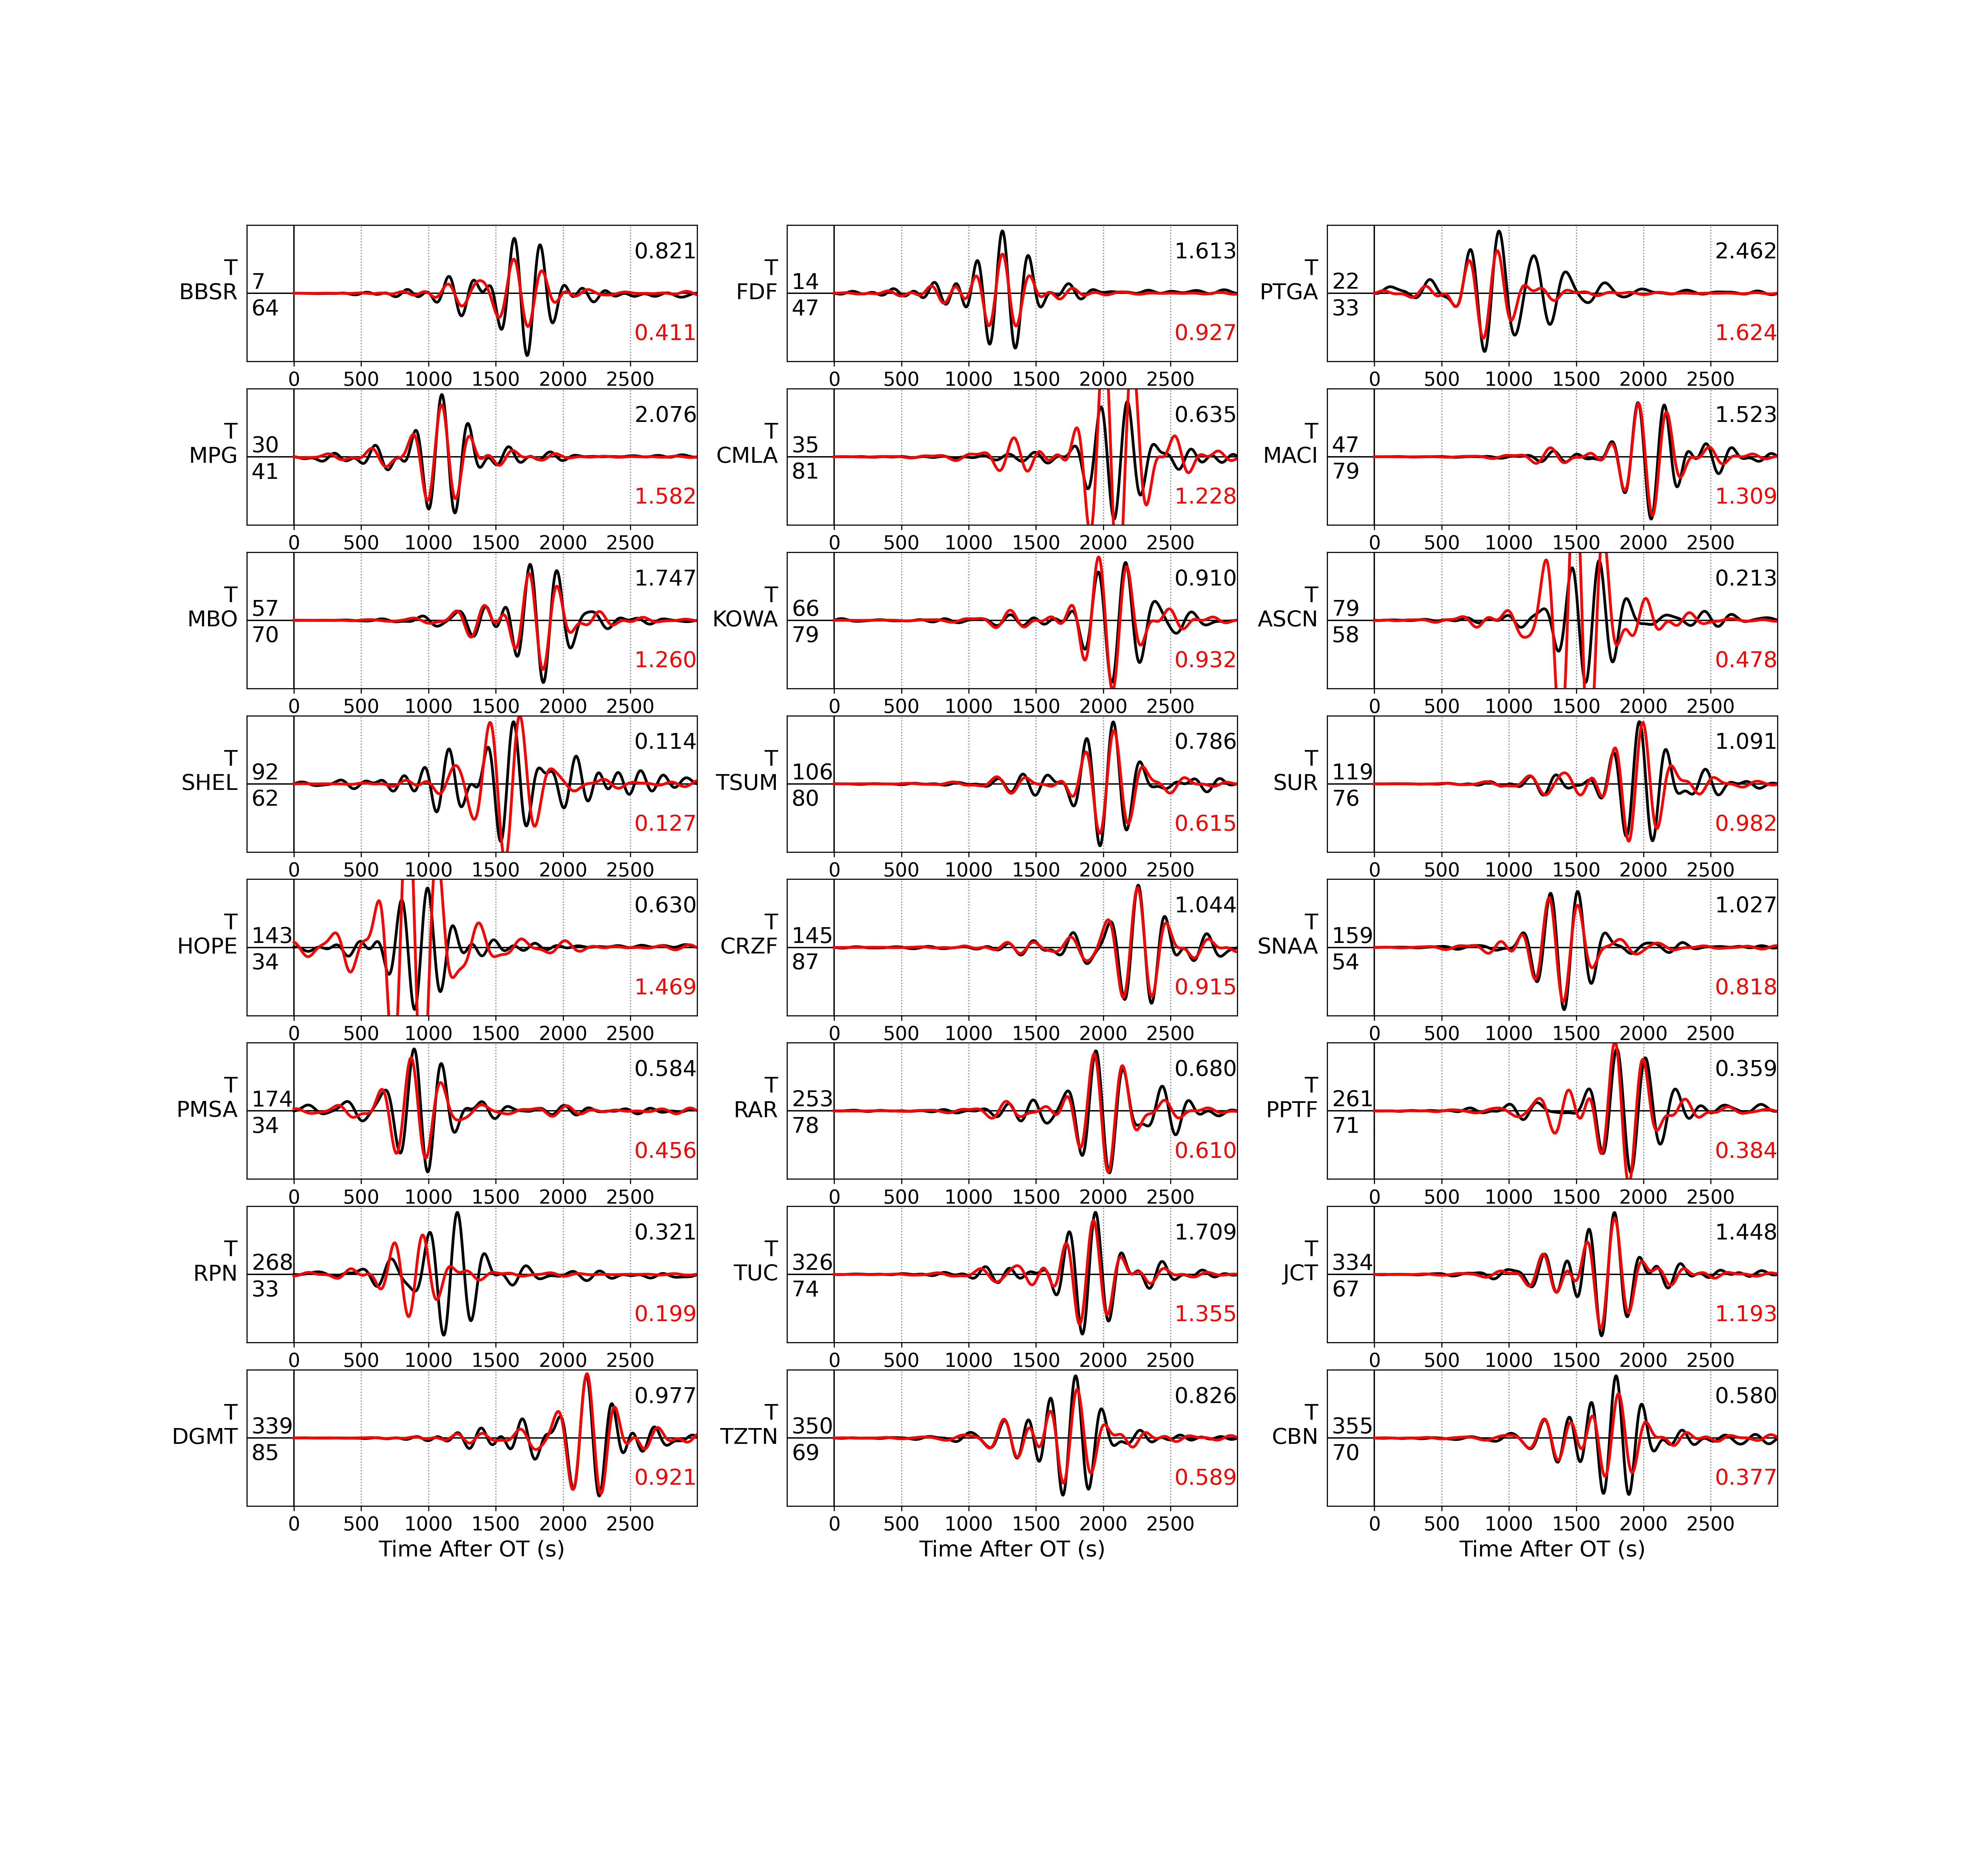

In [23]:
# Let's look at the Love wave fits.
from IPython import display
display.Image(f'{WASP_tutorial}/{event_OT}/{ffm_run}/NP1/plots/Love_surf_waves.png')

Note that a few of these stations are wonky looking. For example, HOPE appears to be off in both amplitude and frequency, as are ASCN and CMLA. Keep these in mind. In the subsequent inversion, we can downweight poor stations to get a more reliable solution.

# <a id='iterate'></a> 3. Let's iterate!

In [26]:
# First, let's update the solution for NP1 in a new directory called NP1.0 so we don't lose the auto inversion
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0

In [31]:
# Let's look at the .json files that allow you to make modifications to your next iteration
!ls {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0/*json

/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/annealing_prop.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/model_space.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/sampling_filter.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/segments_data.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/surf_waves.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/tele_waves.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/tensor_info.json
/data/neic-finitefault/examples/20150916225432/ffm.2/NP1.0/velmodel_data.json


## <a id='input_files'></a>Take a look at the .json files available in the directory.

1. **annealing_prop.json:** Includes parameters for the simulated annealing, which you can adjust here.
2. **model_space.json:** Describes how different fault segments connect (if applicable) and also limits max slip and slip at fault edges, if desired.
3. **sampling_filter.json:** Describes the filter parameters used in data processing.
4. **segments_data.json:** Fault segment information including strike, dip, rake, subfault sizes, hypocenter location on fault
5. **surf_waves.json:** Surface waves (Rayleigh [BHZ] and Love [SH]) included in the inversion and their weights
6. **tele_waves.json:** Teleseismic body waves (P [BHZ] and SH) included in the inversion and their weights
7. **tensor_info.json:** JSON format of the CMT file used as input to the auto inversion. If you want to change hypocenter parameters in future iterations, this is the place to do so.
8. **velmodel_data.json:** 1D velocity structure pulled from LITH1.0 and used for the Green's function calculations. You can substitute a different local 1D structure, but you will have to recalculate all the Green's function banks.

##  <a id='input_files'></a>3.1. Managing .json files and updating .txt files:
Nearly all necessary inversion parameter modifications should be made within the .json files listed above. Modifications made to the .json files are propagated to the necessary .txt files using the command `wasp manage update-inputs`. Whenever a modification is made to a .json file, run `wasp manage update-inputs` with the appropriate flag to corresponding to the .json file you have modified. The most common are listed below:  
1. `-t`: update data types:  
    1.0. `-t body`: updates to the teleseismic body wave data (tele_waves.json)  
    1.1. `-t surf`: updates to the teleseismic surface wave data (surf_waves.json)  
    1.2. `-t strong`: updates to the strong motion accelerometer data (strong_motion_waves.json')  
    1.3. `-t cgps`: updates to the high-rate GPS/GNSS data (cgps_waves.json')  
    1.4. `-t gps`: updates to the static GPS/GNSS data (static_data.json')  
    1.5. `-t insar`: updates to the insar data (insar_data.json')
2. `-p`: updates to the fault plane orientation (segments_data.json) or velocity model (velmodel_data.json)
3. `-a`: updates to the annealing parameters (annealing_prop.json)
4. `-m`: updates to the model space parameters (model_space.json)  

'These .json files won't exist until we add those data to the inversion.

## <a id='modify_jsons'></a>3.2. Remove/ downweight poor stations

Next, we will use `wasp manage modify-dicts` to change the weights of stations in the surf_waves.json or tele_waves.json to zero (using the `downweight`) or remove the station entirely (using the `delete` flag). Open the waveform fit plots to decide which stations you want to downweight or remove. 

Note that station HOPE is super wonky looking in both surface waves (Love and Rayleigh).
We will address this by downweighting the station to zero weight using the command `wasp manage modify-dicts`. We could delete the channel completely, but sometimes modifying other parameters allows stations that look wonky in the automated inversion to fit better later. Downweighting to zero allows you to keep seeing the station fit, so you can upweight it again later if desired.

In [32]:
# First run the help command, -h, to see the options
!wasp manage modify-dicts --help

                                                                                
 Usage: wasp manage modify-dicts [OPTIONS] DIRECTORY MODIFICATION               
                                 DATA_TYPE:{cgps|gps|strong|surf|body}          
                                                                                
 Modify data dictionaries used for managing data                                
                                                                                
╭─ Arguments ──────────────────────────────────────────────────────────────────╮
│ *    directory         PATH                       Path to the data directory │
│                                                   [default: None]            │
│                                                   [required]                 │
│ *    modification      TEXT                       The type of modification   │
│                                                   to apply to the selected   │
│                           

In [35]:
!wasp manage modify-dicts {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 downweight surf -sc "HOPE:BHZ,SH" -sc "ASCN:SH" -sc "RPN:SH" -sc "CMLA:SH"

In [36]:
# Commit these changes by letting the .json files you just modified update their respective text files
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 -t surf

Repeat the process above if you want to downweight (or delete) any other body or surface wave observations

## <a id='segments_data'></a> 3.3. Modify the fault orientation parameters

By default, the planar fault is divided into ~225 subfaults. But these can end up being weird sizes. Open the segments_data.json file in your favorite editor and modify the delta_dip and delta_strike to be equal integers (i.e., square subfaults). If you make these values smaller, you may to add subfaults in the along-strike and along-dip directions (strike_subfaults and dip_subfaults, respectively) to make sure the fault area isn't too small, and you may want to move the hypocenter subfault location (hyp_stk, hyp_dip), to make sure the slip patch fits on the fault area.

<div>
<img src="Tutorial_Figures/Fault_Orientation.png" width="500"/>
</div>

***Figure 1.*** Description of segments_data.json parameters for fault orientation

In [38]:
# Now take a look at the segments_data.json, to modify the fault orientation
with open(f'{WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0/segments_data.json', 'r') as sd:
    print(sd.read())

{
    "rise_time": {
        "delta_rise": 1.5,
        "min_rise": 1.5,
        "windows": 10
    },
    "segments": [
        {
            "delay_segment": 0,
            "delta_dip": 15,
            "delta_strike": 15,
            "dip": 19,
            "dip_subfaults": 9,
            "hyp_dip": 5,
            "hyp_stk": 9,
            "max_vel": 3.125,
            "min_vel": 1.0,
            "neighbours": [],
            "rake": 109,
            "rupture_vel": 2.5,
            "stk_subfaults": 23,
            "strike": 6
        }
    ]
}



Open the segments_data.json in your favorite text editor and change some of the parameters. For example: 
1. make the subfaults 15 x 15 km squares (delta_strike, delta_dip),  
2. Change the number of subfaults along-strike or along-dip (strike_subfaults, dip_subfaults),  
3. Move the entire fault plane relative to the hypocenter location (hyp_stk, hyp_dip)

In [39]:
# Now that you've updated the fault parameters, you have to confirm this 
# change by asking the new .json to overwrite its associated text file.
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 -p

If you've changed the fault parameterization (and/or the waveforms being used), you also have to recalculate the Green's functions. Luckily, `wasp model run` will do this for you. However, you can also do this manually with the command:  
`wasp process greens {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 -t body -t surf`

In [40]:
# now, re-run the inversion:
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 manual_model -t body -t surf

Computing teleseismic GFs

CHEN-JI'S WAVELET KINEMATIC MODELLING METHOD

 Store annealing and modelling parameters...
 Read and store fault segments data to memory...
 Get stations metadata and waveforms and store them in memory...
 Get body waves stations metadata and waveforms...
 Get stations metadata and waveforms for long period surface waves...
 Store GF in memory...
 Store body waves GF in memory...
 Store long period surface waves GF in memory...

 averaged misfit error   1.3594630752787495     
 moment error   6.59457397    
 slip smoothness penalization   911.956970    
 time smoothness penalization   19.5251198    
 total moment of the inversion   3.09927080E+29

moment error coefficient 0.1259463
 slip smoothness penalization coefficient   2.23606461E-04
 time smoothness penalization coefficient   1.04439547E-02

Amount of variables: 1035
 Amount of data values:        12367
 Start simmulated annealing...
   2.07481599    
 iter:            1
   1.91084158    
 iter:       

Let's look at the Love wave fits again. Note that any stations that you deleted are now gone, and any stations you downweighted to zero weight are now shown with dashed lines:

In [ ]:
from IPython import display
display.Image(f'{WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0/plots/Love_surf_waves.png')

Hey that's looking better! 


## <a id='shift_match'></a>3.4. Time shift

Another simple thing we can do to improve the model is to shift the teleseismic waves in time. The calculated P- and S-wave arrival times might not be perfect (i.e., the velocity model isn't perfect), so we run a simple autocorrelation to align the observations and synthetics better in time. Use the command `wasp process-data shift-match` in either `auto` (default) or `manual` mode. `auto` will use the autocorrelation, while `manual` will allow you to shift it by the number of time steps you prefer. Using the `-p` flag will create a series of plots like Figure 2 to show how the waveforms have been shifted.

<div>
<img src="Tutorial_Figures/FDF_SH_shiftmatch.png" width="700"/>
</div>

***Figure 2.*** Example of result of shift_match.py for SH-wave at station FDF.

In [41]:
# First up, teleseismic body waves
!wasp process shift-match {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 body -o auto
# Next up, surface waves
!wasp process shift-match {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 surf -o auto
# Since you've modified the waveform json files, don't forget to make it official:
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 -t body -t surf

In [ ]:
# Alright, let's run that inversion one more time and plot the results
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 manual_model -t body -t surf

### Now you can repeat any of the steps above to modify the fault plane orientation in segments_data.json, remove or down-weight waveforms, shift waveforms in time to align better.

## 3.5.  <a id='velmod'></a> Modify crustal velocity model

WASP automatically selects a 1D crustal velocity model from the centroid location using LITHO1.0 (https://doi.org/10.1002/2013JB010626). If you have a more specific local velocity model, you can substitute it. It's best to substitute **before** adding local data, to avoid having to recalculate local Green's functions, which can take a while.

<div>
<img src="Tutorial_Figures/Chile_crustal_velocity_model.png" width="500"/>
</div>

***Figure 3.*** 1D crustal velocity model for Northern Chile, from LITHO1.0

To modify the local velocity model, open the velmodel_data.json file and input a value for each layer in the velocity model. Run `wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 -p` to commit the changes in velmodel_data.json to the corresponding text file, vel_model.txt.

# <a id='add_data'></a>4. And next, we can add local data!

## <a id='strong'></a>4.1. Add  strong motion data.

In [42]:
# Move the strong motion accelerometer data (Strong_Motion_Data) to the inversion directory folder:
%cp {WASP_tutorial}/StrongMotion_Accelerometer_Data/* {WASP_tutorial}/{event_OT}/{ffm_run}/data/

In [43]:
# Make a new folder to work in so you don't lose your history:
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.0 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.1

In [44]:
# Use the "manual_model_add_data" option on "wasp model run"
# Give it the path to the data directory where you just copied the data (-d ../data/)
# Tell it you want it to add the strong motion data (-t strong)
# FYI this will take a while, because it also needs to calculate local Green's functions!
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.1 manual_model_add_data \
    -d {WASP_tutorial}/{event_OT}/{ffm_run}/data \
    -t strong

INFO - Process strong motion data
INFO - Remove response for selected strong motion traces
INFO - Select strong motion traces
INFO - Update duration of traces
INFO - Process selected strong motion traces
Baseline removal procedure
INFO - Strong motion waves have been succesfully processed
 Get velocity model...
 Load bessel functions to memory...
 Input the number of distance ranges
 Compute near field GF at fixed depth...
 Input thickness Vp Vs rho Qa Qb for layer           1
   1   0.07   3.35   1.44   2.04 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           2
   2   0.93   6.23   3.61   2.71 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           3
   3  11.15   6.23   3.61   2.71 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           4
   4  12.94   6.75   3.87   2.83 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           5
   5  15.80   7.65   4.36   2.97 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer 

Go check out the plots from this run. Note that although plots are automatically made when you run the inversion, you can also manually run plots with additional flags. Let's run the help command to take a look:

In [ ]:
!wasp plot neic --help

Let's try re-plotting this solution manually, using the `-l` flag to include the strong-motion station names on the plot, or modify the command below with the flags you'd like from the help command above:

In [ ]:
!wasp plot neic {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.1 -ffms -t body -t surf -t strong -l

## <a id='cgps'></a> 4.2. Now let's add the high-rate GNSS data, same process.

In [45]:
# Make a new folder to work in so you don't lose your history:
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.1 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.2

In [46]:
# Move the continous GPS data (HR_GNSS_Data) to the inversion directory folder:
%cp {WASP_tutorial}/HighRateGNSS_Data/* {WASP_tutorial}/{event_OT}/{ffm_run}/data/

In [47]:
# Use the "manual_model_add_data" option on "wasp model run"
# Give it the path to the data directory where you just copied the data (-d ../data/)
# Tell it you want it to add the strong motion data (-t cgps)
# FYI this will take a while, because it also needs to calculate local Green's functions!
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.2 manual_model_add_data \
    -d {WASP_tutorial}/{event_OT}/{ffm_run}/data \
    -t cgps

INFO - Process cGPS data
INFO - Select cGPS traces
INFO - Process selected cGPS traces
INFO - cGPS waves have been succesfully processed
 Get velocity model...
 Load bessel functions to memory...
 Input the number of distance ranges
 Compute near field GF at fixed depth...
 Input thickness Vp Vs rho Qa Qb for layer           1
   1   0.07   3.35   1.44   2.04 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           2
   2   0.93   6.23   3.61   2.71 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           3
   3  11.15   6.23   3.61   2.71 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           4
   4  12.94   6.75   3.87   2.83 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           5
   5  15.80   7.65   4.36   2.97 0.12E+04 0.60E+03
 Input thickness Vp Vs rho Qa Qb for layer           6
   6 196.00   8.08   4.47   3.38 0.12E+04 0.50E+03
 Input thickness Vp Vs rho Qa Qb for layer           7
   7  36.00   8.59   4.66   3.45 0.

In [ ]:
# OPTIONAL: If you want to have station ID labels on the map, you can re-run the plot command with the -l flag:
!wasp plot neic {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.2 -ffms -t body -t surf -t strong -t cgps -l

## Now we have all the kinematic data included, let's move onto the static data
### <a id='gps'></a> 4.3. Starting with the static GNSS/GPS data

In [ ]:
# Make a new folder so you don't lose your history:
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.2 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3

In [ ]:
# Move the gps_data text file into your working directory:
!cp {WASP_tutorial}/Static_Data/gps_data {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3/

In [ ]:
# Use the gps_data file to create the necessary .json file:
!wasp manage fill-dicts {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 -t gps

In [ ]:
# Use 'wasp manage update-inputs' to make the update to the json official:
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 -t gps

In [ ]:
# Now we have to make Green's functions for the static station locations:
!wasp process greens {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 -t gps

In [ ]:
# Alright, run a new inversion (and make plots) with all the available data so far!
# Keep in mind that every time you add new data, the inversion will take a bit longer...
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 manual_model -t body -t surf -t strong -t cgps -t gps

In [ ]:
# OPTIONAL: to add station ID to all the local stations, replot with the -l flag:
!wasp plot neic {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 -ffms -t body -t surf -t strong -t cgps -t gps -l

## Looking good! <a id='insar'></a> 4.4. Time for InSAR data:
### Prior to inclusion in WASP, InSAR observations must be processed to line-of-sight displacements, and down-sampled to some tractable number of observations (~1000 points per scene). Use the format in the example data files. Denote any header lines with '#'

In [ ]:
# Make a new folder so you don't lose your history:
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.3 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4

In [ ]:
# Copy the downsampled InSAR data into the working directory
!cp {WASP_tutorial}/Static_Data/s1_20150824-20150917_p156_descending.txt {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4/
!cp {WASP_tutorial}/Static_Data/s1_20150826-20150919_p18_ascending.txt {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4/

In [ ]:
# Make the necessary InSAR json files:
# For organization (it doesn't matter for the inversion), mark the ascending file as -ina
# Mark the descending file as -ind
# WASP can allow for linear, bilinear, and quadratic "ramps" for each scene
# Ramps are are specified by ":<ramp type>" to the file path.
# Here, we'll use the simplest version, linear ramps, for both.
!wasp manage fill-dicts {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4 \
    -t insar \
    -ina {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4/s1_20150826-20150919_p18_ascending.txt:linear \
    -ind {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4/s1_20150824-20150917_p156_descending.txt:linear;

In [ ]:
# Use 'wasp manage update-inputs' to make the update to the json official:
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4 -t insar

In [ ]:
# Calcluate Green's functions.
# With a lot of data points, this could take a few minutes
!wasp process greens {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4 -t insar

In [ ]:
# Re-run the inversion with all the data!
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4 manual_model -t body -t surf -t strong -t cgps -t gps -t insar

### And there you have it, a finite fault model that includes many different instrument types.
Go check out your plots! To finalize the inversion, go back and modify the fault orientation, subfault size, shift waveforms in time to match synthetics to observations better, remove bad stations, etc.

# <a id='multi_segment'></a> 5. Multi-segment models
At present, WASP requires that slip be solved for on planar faults. However, we are not limited to one fault segment. WASP can model on 2+ planar segments, either connected at fault edges or completely independent. The 2015 Illapel earthquake ruptured only one fault (the megathrust), however, we can do a better job mimicking the increasing dip of the subduction zone with depth by changing our model from one plane with constant dip to two planes, with the deeper plane having slightly steeper dip.

To include more than one planar fault segment, you must adjust two files:  
1. segments_data.json  
* Use hyp_stk and hyp_dip to locate the fault, relative to the location of the hypocenter
* Use the “connections” field to describe how multiple planes are connected, in order to facilitate smoothing across the faults.
2. model_space.json
* Specify any constraints on slip amplitudes and allowable rakes
* Specify whether plane is connected to any other planes in the up- or down-dip directions, or to the left or right (i.e., in the negative or positive along-strike directions)

Examples of how you might modify these two files are in the Multisegment_Example folder.


<div>
<img src="Tutorial_Figures/Multi_Segment_Positions.png" width="500"/>
</div>

***Figure 4.*** Example of determining "hyp_stk" and "hyp_dip" for multi-segment models connected along-strike (segment 2) or along-dip (segment (3).

In our case, the bottom of the shallow plane is connected to the top of the deeper plane. However, segments need not be connected at all- this is how you might model two events in close spatiotemporal proximity at once (e.g., Yeck et al., 2023). 

* Yeck, W.L. et al. Dense geophysical observations reveal a triggered, concurrent multi-fault rupture at the Mendocino Triple Junction. Commun Earth Environ 4, 94 (2023). https://doi.org/10.1038/s43247-023-00752-2

In [ ]:
# Make a new folder so you don't lose your history:
!cp -r {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.4 {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.5

In [ ]:
# Copy the example segments_data.json and model_space.json from the Multisegment_Example directory:
!cp {WASP_tutorial}/Multisegment_Example/segments_data.json {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.5/
!cp {WASP_tutorial}/Multisegment_Example/model_space.json {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.5/
# Run 'wasp manage update-inputs' to update the text files associated with those json files:
!wasp manage update-inputs {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.5 -p -m

In [ ]:
# This command will now update the Green's funcitons for the new configuation, run the inversion, and plot the results:
!wasp model run {WASP_tutorial}/{event_OT}/{ffm_run}/NP1.5 manual_model -t body -t surf -t strong -t cgps -t gps -t insar


In these results, you will see some subtle changes. First, you now have 2 SlipDist plots, one for each plane. Also, when you open the Map plot, you'll see the two segments are separated, and there are now two red up-dip edges, one for each plane. This is fairly simplistic version of a multi-segment model, but users are encouraged to make their own more complex multi-segment models!

### Congrats! You are ready to explore WASP on your own and model earthquakes of interest to you!